In [1]:
import torch
from torch import nn
from transformers import PreTrainedTokenizerFast, AutoTokenizer
from datasets import load_dataset
from evaluate import load, combine
from tqdm import tqdm

from transformer import *
from dataset import *

from numba import cuda
device = cuda.get_current_device()
device.reset() 

In [2]:
import sys
sys.path.append('../')
from custom_tokenizers.tokenizerv1 import parse_sentence
import json

In [3]:
# get data 
train = load_dataset('csv', data_files='../data/train.csv')['train']
test = load_dataset('csv', data_files='../data/test.csv')['train']
VAL_CUTOFF = 500 # random choice for val loss, full test set is 3110, take 500 away for validation only. 
val = test[:VAL_CUTOFF]
test = test[VAL_CUTOFF:]

# obolo_tokenizer = PreTrainedTokenizerFast(tokenizer_file='../custom_tokenizers/obolo-bpe-tokenizer.json', padding='left')
english_tokenizer = AutoTokenizer.from_pretrained('gpt2', padding='left')

# we construct this vocab by calculating tokens from train data
# obolo_vocab_sents = [set(parse_sentence(s)) for s in train['Obolo']]
# obolo_vocab = set()
# for sent in obolo_vocab_sents:
#     obolo_vocab.update(sent)
# obolo_vocab = special_tokens + list(obolo_vocab)
# obolo_vocab = {token:idx for idx, token in enumerate(obolo_vocab)}

# Serialize data into file:
# json.dump( obolo_vocab, open( "../custom_tokenizers/custom_obolo_tokenizer_vocab.json", 'w' ) )

# Read data from file:
obolo_vocab = json.load( open( "../custom_tokenizers/custom_obolo_tokenizer_vocab.json" ) )

print(len(obolo_vocab))
print(len(english_tokenizer.vocab))

print(DEVICE)

token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = parse_sentence
token_transform[TGT_LANGUAGE] = english_tokenizer

vocab_transform[SRC_LANGUAGE] = obolo_vocab 
vocab_transform[TGT_LANGUAGE] = english_tokenizer.vocab

# change this due to custom tokenizer
# init_text_transform(token_transform)
text_transform[SRC_LANGUAGE] = sequential_transforms((lambda text: [obolo_vocab[token] if token in obolo_vocab else UNK_IDX for token in token_transform[SRC_LANGUAGE](text)]), # input to tokens to ids
                                                     tensor_transform)                                                                                                          # add BOS/EOS and create tensor

text_transform[TGT_LANGUAGE] = sequential_transforms((lambda text: token_transform[TGT_LANGUAGE](text).get('input_ids')),
                                                     tensor_transform)    


6864
50257
cuda


In [4]:
ob_sent, en_sent = train['Obolo'][0], train['English'][0]
print(ob_sent)
print(parse_sentence(ob_sent))
print(text_transform[SRC_LANGUAGE](ob_sent))
print([obolo_vocab[token] for token in token_transform[SRC_LANGUAGE](ob_sent)] == list(text_transform[SRC_LANGUAGE](ob_sent))[1:-1])
print(en_sent)
print(text_transform[TGT_LANGUAGE](en_sent))

eya orọ, nnenikana isi lek ogwukaan̄-ene awaji, mè ito ito inyi, mè iriaak uriaak, mè ibeek mbeek, mè ijin otu, mè itap ofọnti ufieejit, mè ifuun̄ lek me ntọn̄.
['e', 'ya', 'o', 'rọ', ',', 'n', 'neni', 'kana', 'i', 'si', 'lek', 'ogwukaan̄', '-', 'e', 'ne', 'awaji', ',', 'mè', 'i', 'to', 'i', 'to', 'i', 'nyi', ',', 'mè', 'i', 'riaak', 'uriaak', ',', 'mè', 'i', 'beek', 'm', 'beek', ',', 'mè', 'i', 'jin', 'o', 'tu', ',', 'mè', 'i', 'tap', 'ofọnti', 'ufieejit', ',', 'mè', 'i', 'fuun̄', 'lek', 'me', 'n', 'tọn̄', '.']
tensor([   1, 3663, 4948, 2148, 2510, 2491, 6404, 4761, 6466, 1347, 5593, 5110,
        5583, 2024, 3663, 1519, 3486, 2491, 3865, 1347, 1128, 1347, 1128, 1347,
         443, 2491, 3865, 1347, 5579,  136, 2491, 3865, 1347, 3847, 4775, 3847,
        2491, 3865, 1347, 3084, 2148, 1164, 2491, 3865, 1347, 6278, 5203, 6492,
        2491, 3865, 1347,  278, 5110, 3449, 6404, 2887, 6770,    2])
True
and i set my face unto the lord god, to seek by prayer and supplications, wi

In [5]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(obolo_vocab)
TGT_VOCAB_SIZE = english_tokenizer.vocab_size
# ORIGINAL TRANSFORMER CONFIGURATION
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

# TWEAKS ARE BAD, JUST USE DEFAULT CONFIG
# EMB_SIZE = 512
# NHEAD = 16
# FFN_HID_DIM = 512
# BATCH_SIZE = 64
# NUM_ENCODER_LAYERS = 6
# NUM_DECODER_LAYERS = 6

train_dataloader = generate_dataloader(train['Obolo'], train['English'], BATCH_SIZE)
val_dataloader = generate_dataloader(val['Obolo'], val['English'], BATCH_SIZE)
test_dataloader = generate_dataloader(test['Obolo'], test['English'], BATCH_SIZE)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
display(transformer)
display(optimizer)

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.98)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [7]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        # save vram 
        del src, tgt
        torch.cuda.empty_cache()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

        # save vram 
        del src, tgt
        torch.cuda.empty_cache()

    return losses / len(list(val_dataloader))

In [8]:
from timeit import default_timer as timer

# NUM_EPOCHS = 10
NUM_EPOCHS = 30 

train_losses = []
val_losses = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    if epoch % 5 == 0:
        torch.save(transformer, f'checkpoints/transformer_obolo_to_english_custom_{epoch}_epochs.pt')

  0%|          | 0/438 [00:00<?, ?it/s]c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 438/438 [15:49<00:00,  2.17s/it]


Epoch: 1, Train loss: 5.914, Val loss: 4.670, Epoch time = 965.005s


100%|██████████| 438/438 [15:48<00:00,  2.17s/it]


Epoch: 2, Train loss: 4.377, Val loss: 4.065, Epoch time = 964.593s


100%|██████████| 438/438 [15:51<00:00,  2.17s/it]


Epoch: 3, Train loss: 3.952, Val loss: 3.776, Epoch time = 967.839s


100%|██████████| 438/438 [15:42<00:00,  2.15s/it]


Epoch: 4, Train loss: 3.693, Val loss: 3.576, Epoch time = 958.587s


100%|██████████| 438/438 [15:51<00:00,  2.17s/it]


Epoch: 5, Train loss: 3.498, Val loss: 3.430, Epoch time = 967.512s


100%|██████████| 438/438 [15:51<00:00,  2.17s/it]


Epoch: 6, Train loss: 3.339, Val loss: 3.310, Epoch time = 967.051s


100%|██████████| 438/438 [15:44<00:00,  2.16s/it]


Epoch: 7, Train loss: 3.205, Val loss: 3.219, Epoch time = 960.401s


100%|██████████| 438/438 [15:47<00:00,  2.16s/it]


Epoch: 8, Train loss: 3.087, Val loss: 3.143, Epoch time = 963.745s


100%|██████████| 438/438 [15:50<00:00,  2.17s/it]


Epoch: 9, Train loss: 2.982, Val loss: 3.079, Epoch time = 966.625s


100%|██████████| 438/438 [15:45<00:00,  2.16s/it]


Epoch: 10, Train loss: 2.885, Val loss: 3.016, Epoch time = 961.489s


100%|██████████| 438/438 [15:45<00:00,  2.16s/it]


Epoch: 11, Train loss: 2.794, Val loss: 2.963, Epoch time = 961.730s


100%|██████████| 438/438 [16:10<00:00,  2.22s/it]


Epoch: 12, Train loss: 2.712, Val loss: 2.927, Epoch time = 986.149s


100%|██████████| 438/438 [15:54<00:00,  2.18s/it]


Epoch: 13, Train loss: 2.633, Val loss: 2.895, Epoch time = 969.907s


100%|██████████| 438/438 [15:54<00:00,  2.18s/it]


Epoch: 14, Train loss: 2.560, Val loss: 2.866, Epoch time = 970.100s


100%|██████████| 438/438 [16:05<00:00,  2.21s/it]


Epoch: 15, Train loss: 2.489, Val loss: 2.837, Epoch time = 981.688s


100%|██████████| 438/438 [15:55<00:00,  2.18s/it]


Epoch: 16, Train loss: 2.421, Val loss: 2.816, Epoch time = 971.093s


100%|██████████| 438/438 [15:56<00:00,  2.18s/it]


Epoch: 17, Train loss: 2.357, Val loss: 2.797, Epoch time = 972.477s


100%|██████████| 438/438 [15:47<00:00,  2.16s/it]


Epoch: 18, Train loss: 2.291, Val loss: 2.778, Epoch time = 963.609s


100%|██████████| 438/438 [15:44<00:00,  2.16s/it]


Epoch: 19, Train loss: 2.219, Val loss: 2.747, Epoch time = 960.121s


100%|██████████| 438/438 [15:53<00:00,  2.18s/it]


Epoch: 20, Train loss: 2.151, Val loss: 2.734, Epoch time = 969.421s


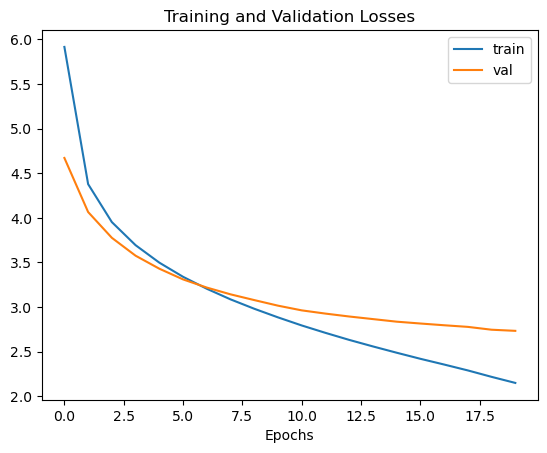

In [9]:
import matplotlib.pyplot as plt 
import numpy as np

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.show()

In [29]:
torch.save(transformer.state_dict(), 'transformer_obolo_to_english_custom_dict.pt')

In [30]:
torch.save(transformer, 'transformer_obolo_to_english_custom.pt')

In [31]:
m=torch.load('transformer_obolo_to_english_custom.pt')
m

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [4]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        # print(out)
        # print(english_tokenizer.decode(out))
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        # print(next_word)
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # save vram
        del tgt_mask
        torch.cuda.empty_cache()
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    
    return token_transform[TGT_LANGUAGE].decode(tgt_tokens[1:-1])
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("[CLS]", "").replace("[SEP]", "")


In [35]:
# src_sentence = "ire, emi okumugwem mâtap oke me etete anam ebi ijeren mè echi ebi ijipiti. anam geege me etete echi ebi ijeren ìkpokwu"
# src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
# print(list(src.numpy().flatten()), src.shape)
# print(token_transform[SRC_LANGUAGE].decode(src.numpy().flatten()))

In [41]:
ob, en = test['Obolo'][100], test['English'][100]
print(ob)
print(translate(m, ob))
print(en)

mgbọ yaage îmun̄be ife chi egwookbe, ibebene ikaan̄ ulọk me lek kiban̄, mè iria osat isi lek kiban̄ me kalidia.
and it came to pass, when they saw that they had seen, that they sent to the sea, and sent them to the chaldeans, and sent to the chaldeans.
and as soon as she saw them with her eyes, she doted upon them, and sent messengers unto them into chaldea.


In [11]:
sentence = "ogwu ubọọn̄ oneniyaka ido siba ibe, “sà gwun̄ nte uwu kwun̄ ìkup me owa?” siba ofọfọọk ibe ke ọmọ òwa me jeruselem okupbe, mije, ìkikeek ibe, usini mgbọ, cherekeyi, ke ebi uwu kè ijeren mêniyaka irek mkpulu nte nte kan̄ inyi ọmọ."
print(translate(transformer, sentence))

and he said unto his house, where [is] thy son? and he said, i [am] the house of israel, and the house of my father’s house [is] in jerusalem: and i will go up to jerusalem, and i will go into the house of judah: and he shall be his father’s house.


MAKE TRANSLATE ACTUALLY WORK !!!

In [5]:
m_20=torch.load('checkpoints/transformer_obolo_to_english_custom_20_epochs.pt').to(DEVICE)
m_10=torch.load('checkpoints/transformer_obolo_to_english_custom_10_epochs.pt').to(DEVICE)

In [6]:
m_20

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [7]:
m_10

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [8]:
def test_model(m):
    preds = []
    refs = []
    for idx in tqdm(range(len(test['Obolo']))):
        ob, en = test['Obolo'][idx], test['English'][idx]
        refs.append(en)
        pred = translate(m, ob)
        preds.append(pred)
    print(len(preds), len(refs))
    chrf = load('chrf')
    gleu = load('google_bleu')
    rouge = load('rouge') 
    bleu = load('bleu')
    meteor = load('meteor')
    metrics = combine([chrf, bleu, rouge, meteor, gleu])
    return metrics.compute(predictions=preds, references=refs)

In [9]:
scores_20 = test_model(m_20)
scores_10 = test_model(m_10)
display(scores_20, scores_10)

  0%|          | 0/2610 [00:00<?, ?it/s]c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 2610/2610 [43:43<00:00,  1.01s/it]  


2610 2610


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 2610/2610 [24:30<00:00,  1.78it/s]


2610 2610


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'score': 30.43952826900615,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.0822760096610319,
 'precisions': [0.34278131844280896,
  0.11676725534672716,
  0.04780428948846498,
  0.023949022794337766],
 'brevity_penalty': 1.0,
 'length_ratio': 1.2602981585785868,
 'translation_length': 101362,
 'reference_length': 80427,
 'rouge1': 0.335296424230112,
 'rouge2': 0.11263883371236624,
 'rougeL': 0.27648851078468684,
 'rougeLsum': 0.27663804352919213,
 'meteor': 0.28851067939375274,
 'google_bleu': 0.13259436788496107}

{'score': 33.6596090739384,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.11152622811206186,
 'precisions': [0.3960213311587283,
  0.15589433362402993,
  0.07046159791763756,
  0.0355636772561147],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1587775249605232,
 'translation_length': 93197,
 'reference_length': 80427,
 'rouge1': 0.37848096078159404,
 'rouge2': 0.14502733811072638,
 'rougeL': 0.32143027570595695,
 'rougeLsum': 0.32138612077297485,
 'meteor': 0.32787793097157697,
 'google_bleu': 0.16055082533221088}

In [ ]:
test['Obolo'] = val['Obolo']+test['Obolo']
print(len(test['Obolo']))
scores_10 = test_model(m_10)
display(scores_10)
scores_20 = test_model(m_20)
display(scores_20)
# display(scores_20, scores_10)

In [13]:
print(len(preds), len(refs))

2610 2610


In [14]:
# metrics
chrf = load('chrf')
gleu = load('google_bleu')
rouge = load('rouge') 
bleu = load('bleu')
meteor = load('meteor')
metrics = combine([chrf, bleu, rouge, meteor, gleu])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
scores = metrics.compute(predictions=preds, references=refs)
scores

{'score': 30.43952826900615,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.0822760096610319,
 'precisions': [0.34278131844280896,
  0.11676725534672716,
  0.04780428948846498,
  0.023949022794337766],
 'brevity_penalty': 1.0,
 'length_ratio': 1.2602981585785868,
 'translation_length': 101362,
 'reference_length': 80427,
 'rouge1': 0.3352499302267455,
 'rouge2': 0.11275906915007564,
 'rougeL': 0.27644615250839405,
 'rougeLsum': 0.2763975206470654,
 'meteor': 0.28851067939375274,
 'google_bleu': 0.13259436788496107}